In [1]:
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
from math import log,sqrt,pi

Here's some data I recorded earlier... from a step of size 0.05 upwards.  The "fgplot" module also provides a raw data import facility.

Opening logs/fglog191010135444.csv
Processed 168 lines.


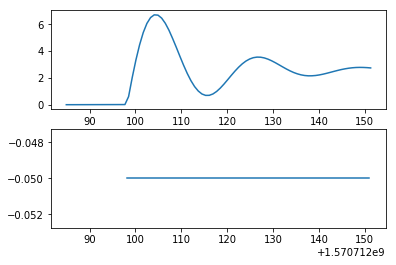

In [2]:
from fgplot import import_log
data_dict = import_log('logs/fglog191010135444.csv')

plt.figure()
ax=plt.subplot(2,1,1)
(th,h)=data_dict['/velocities/vertical-speed-fps']
plt.plot(th,h)

plt.subplot(2,1,2,sharex=ax)
(te,e)=data_dict['/controls/flight/elevator']
plt.plot(te,e)

plt.show()

We're going to use the *log decrement* method to identify a model of our dynamic system.  Recognizing that it looks like a standard second order response - a decaying wave - we can estimate the model parameters using standard observations.  Embarassingly, the method is described very well on its [wikipedia page](https://en.wikipedia.org/wiki/Logarithmic_decrement).

Start by recording some key observations from the plot.  I recommend you use fgplot.py at the command line so you can take measurements with the cursor.

In [3]:
p1 = 13.4 # peak 1 height
p2 = 7.6 # peak 2 height
y0 = 1.2 # initial output
yss = 5.5 # steady state output
uss = -0.05 # input step
T = 93-72 # time between peaks

Now use the standard log decrement formulae to get the key paramaters: the damping ratio *zeta* and the undamped natural frequency *wn*.

In [4]:
logdec = log((p1-yss)/(p2-yss))
print('logdec=',logdec)
zeta = 1/sqrt(1+(2*pi/logdec)**2)
print('zeta=',zeta)
wd = 2*pi/T
print('wd=',wd)
wn = wd/sqrt(1-zeta**2)
print('wn=',wn)

logdec= 1.3249254147435987
zeta= 0.2063310147175011
wd= 0.2991993003418851
wn= 0.30577897609210164


Now we use another standard formula (see [here](https://apmonitor.com/pdc/index.php/Main/SecondOrderSystems) for background) to write the model of the system in *state space form* (see [here](https://en.wikipedia.org/wiki/State-space_representation#Linear_systems) for standard equations). 

In [5]:
A = np.array([[0,1],[-wn*wn,-2*zeta*wn]])
B = np.array([[1.0],[0.0]])
C = np.array([[wn*wn,0]])*400.0 # manually adjusted to fit
D = np.array([0])
print('A=',A)
print('B=',B)
print('C=',C)
print('D=',D)

A= [[ 0.          1.        ]
 [-0.09350078 -0.12618337]]
B= [[1.]
 [0.]]
C= [[37.40031289  0.        ]]
D= [0]


We ought to compare it to the original data.  You'll need to adjust the gain in the C equation above to suit.

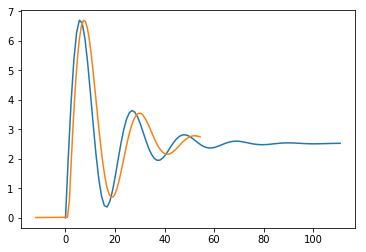

In [6]:
(t,y) = scipy.signal.step((A,B,C,D))
plt.plot(t,y*-uss)
plt.plot([tv - th[0]-12 for tv in th],h) # manually put in a time offset to ease comparison
plt.show()

Let's look at the eigenvalues of the A matrix, which are the *poles* of the system.  See [here](https://en.wikipedia.org/wiki/Closed-loop_pole) for background.  More information on how to interpret the poles can be found [here](https://uk.mathworks.com/help/control/ref/pzmap.html), including the extremely useful map of damping and frequency in terms of pole locations.  Do these pole values match the predictions of our system model, *zeta* and *wn*?

In [7]:
w,v = np.linalg.eig(A)
w

array([-0.06309169+0.2991993j, -0.06309169-0.2991993j])

How does the gain change the poles?  We'll explore this numerically, by just trying different values and finding the eigenvalues again.  This plot is called the *root locus* and there are cleverer methods to predict its shape - see [here](https://en.wikipedia.org/wiki/Root_locus).

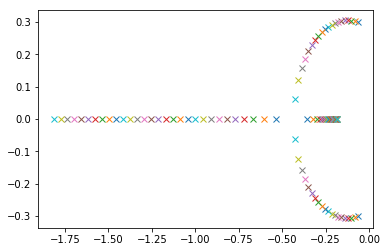

In [8]:
plt.figure()
for kp in np.linspace(0,0.05):
    Acl = A-kp*np.dot(B,C)
    w,v = np.linalg.eig(Acl)
    plt.plot(np.real(w),np.imag(w),'x')
plt.show()

There's an interesting point where the two poles both hit the real axis - this point should have no oscillations.  Try and find the gain that achieves this.  (There are more advanced ways to achieve *pole placement* but they're beyond our scope.)

In [9]:
kp = 0.0204 # adjust this gain manually
Acl = A-kp*np.dot(B,C)
w,v = np.linalg.eig(Acl)
w

array([-0.53330125, -0.35584851])

Let's see what the response looks like by simulating the model's step response.  The multiplication by 5 denotes that the step will be a demand of 5 FPS. 

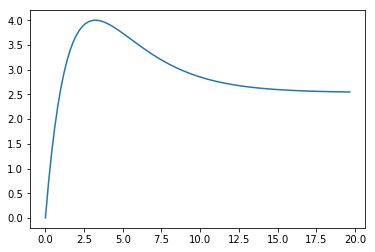

In [10]:
(t,y) = scipy.signal.step((Acl,5*B*kp,C,D))
plt.plot(t,y)
plt.show()

Here's the result of a simulation using vs_p.py, still with a step demand of 5 FPS, and the gain determined above.  Not too bad...

Opening logs/fglog191010160201.csv
Processed 165 lines.


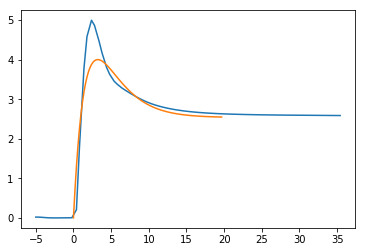

In [11]:
data_dict = import_log('logs/fglog191010160201.csv')

(tv,v) = data_dict['/velocities/vertical-speed-fps']
tv2 = [ti - tv[0]-5 for ti in tv]
plt.figure()
plt.plot(tv2,v,t,y)
plt.show()

**Exercise**: essentially, repeat!  You'll get a different system model depending on things like altitude, throttle setting, and so on.  Model your aircraft and deploy a controller on it.  *Success* means your results match your predictions, reasonably enough.